In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg 
from sklearn.metrics import mean_squared_error

In [2]:
train_data = pd.read_csv('data_train.csv', index_col=['timestamp'], parse_dates=['timestamp'])
train_data = train_data.asfreq('h') #  чтобы не появлялось исключение при обучении модели

In [3]:
def prepare_data(data):        
    x = data.drop(["fact"], axis=1)
    y = data["fact"]    
    return x, y

x_train, y_train = prepare_data(train_data)

In [4]:
# в качестве лагов выбраны значения +-4 часа от текущего часа 7 дней назад
lags_len = 9
lags = np.arange(-lags_len//2 + 1 , lags_len//2 + 1)
for j in range(lags_len):
    lags[j] += 24*7
    
print(lags)

[164 165 166 167 168 169 170 171 172]


In [5]:
model = AutoReg(y_train, lags = lags, trend = 't', old_names = True, seasonal = True, period = 24*7)
model_fit = model.fit()

In [6]:
predictions = model_fit.predict().dropna()  # некоторое количество строк в начале датафрейма содержат Nan
print('RMSE с января по август:', mean_squared_error(predictions, y_train.iloc[-predictions.shape[0]:], squared = False))

RMSE с января по август: 78.0036486944789


RMSE за последние 30 дней, для которых известно потребление электроэнергии: 50.04615601142484


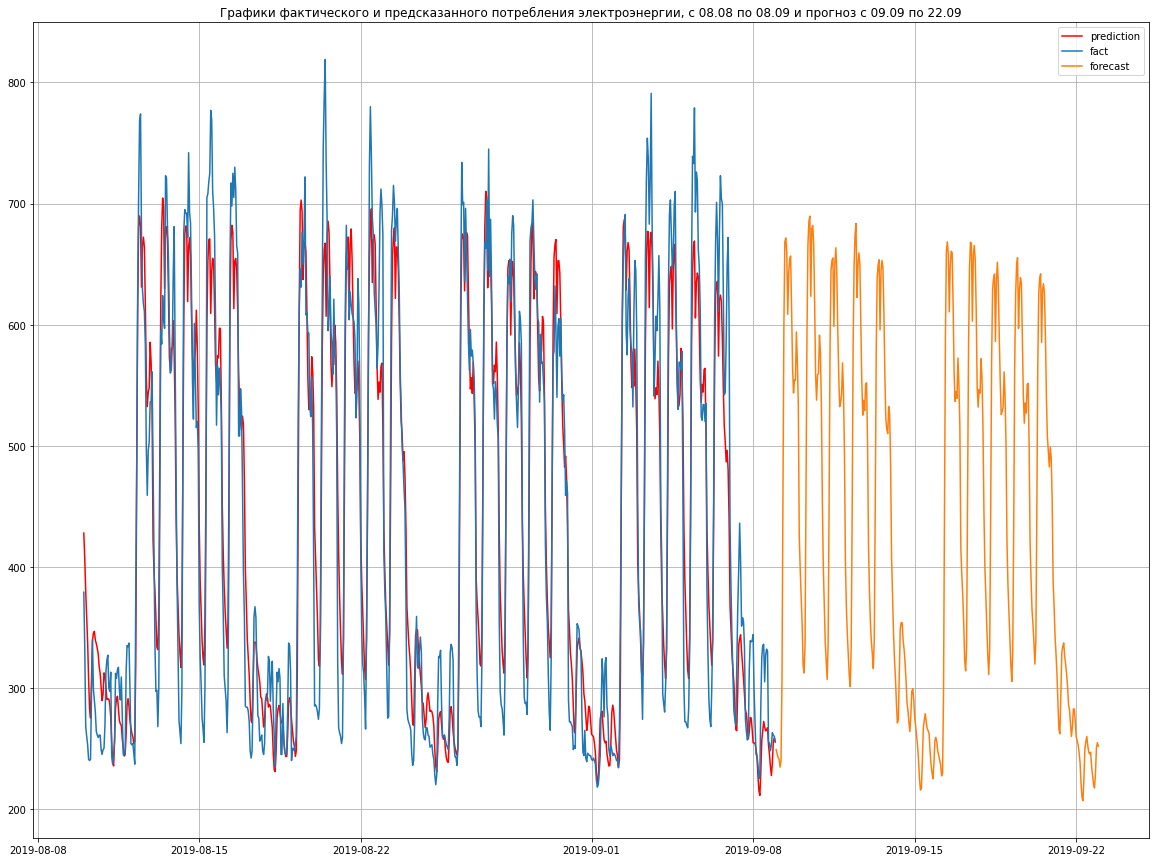

In [7]:
print('RMSE за последние 30 дней, для которых известно потребление электроэнергии:', mean_squared_error(predictions.iloc[-24*30:], y_train.iloc[-24*30:], squared = False))

test_hours_count = len(pd.date_range(start='9-9-2019', end='23-09-2019', freq = 'H')) #  количество часов в тестовом отрезке
forecast =  model_fit.predict(start=len(x_train+1), end=len(x_train)+test_hours_count-2, dynamic=False) #  построение прогноза
forecast = pd.DataFrame(forecast)

plt.figure(figsize=(20, 15))
plt.plot(predictions.iloc[-24*30:], "r", label="prediction")
plt.plot(y_train.iloc[-24*30:], label="fact")
plt.plot(forecast, label="forecast")
plt.legend(loc="best")
plt.title("Графики фактического и предсказанного потребления электроэнергии, с 08.08 по 08.09 и прогноз с 09.09 по 22.09")
plt.grid(True)

In [8]:
x_train.tail()

""
timestamp
2019-09-08 19:00:00
2019-09-08 20:00:00
2019-09-08 21:00:00
2019-09-08 22:00:00
2019-09-08 23:00:00


In [9]:
forecast.reset_index(inplace = True)
forecast.columns = ['timestamp', 'predicted']
forecast.head()

,timestamp,predicted
0,2019-09-09 00:00:00,248.930842
1,2019-09-09 01:00:00,245.736356
2,2019-09-09 02:00:00,242.264456
3,2019-09-09 03:00:00,240.908961
4,2019-09-09 04:00:00,234.553814


In [10]:
forecast.tail()

,timestamp,predicted
331,2019-09-22 19:00:00,217.305027
332,2019-09-22 20:00:00,229.100990
333,2019-09-22 21:00:00,250.510818
334,2019-09-22 22:00:00,254.727855
335,2019-09-22 23:00:00,251.954573


In [11]:
forecast.to_csv("forecast.csv", encoding='utf-8', index=False)